<h2>Sentiment Analysis on Musical Instruments Review</h2>
<h3>Using LSTM</h3>

The data i've used : https://www.kaggle.com/eswarchandt/amazon-music-reviews

In [168]:
import os
import seaborn as sns
import numpy as np
import pandas as pd
import nltk
from collections import Counter
from sklearn.metrics import confusion_matrix
from string import punctuation
from nltk.corpus import stopwords
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
os.chdir("/content/drive/My Drive/Python/Practice/Music instrument")

In [3]:
ls

 Musical_instruments_reviews.csv              New_Approach.ipynb
'Music instrument Sentiment Analysis.ipynb'


In [4]:
df = pd.read_csv("Musical_instruments_reviews.csv")

In [5]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [6]:
new_df = df[['reviewText','overall']]

In [7]:
new_df['sentiment'] = new_df['overall'].apply(lambda x:1 if x>=3 else 0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


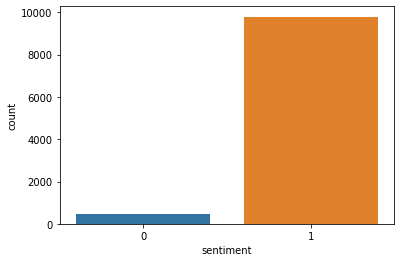

In [8]:
sns.countplot(new_df['sentiment'])

Since we are dealing with highly imbalanced dataset we will equalize it

In [9]:
new_df['sentiment'].value_counts()

1    9794
0     467
Name: sentiment, dtype: int64

Shuffling the dataset

In [124]:
new_df = new_df.sample(frac=1)

In [125]:
positive_reviews = new_df.loc[new_df['sentiment']==1][:500]
negative_reviews = new_df.loc[new_df['sentiment']==0][:500]

In [12]:
positive_reviews.shape
negative_reviews.shape

(467, 3)

In [126]:
train_df = pd.concat([positive_reviews,negative_reviews])

In [210]:
train_df.shape

(967, 3)

In [14]:
reviewText = train_df['reviewText'].values
sentiment = train_df['sentiment'].values

Preprocessing text
*   Lower the string
*   Removing punctuation or digits





In [140]:
final_text = []
for text in reviewText:
  new_text = str(text)
  new_text = text.lower()
  new_text.strip()
  new_text = ''.join([c for c in new_text if c not in punctuation and not c.isdigit()])
  final_text.append(new_text)

In [227]:
all_words = []
for words in final_text:
  split_words = words.split(' ')
  for split in split_words:
    all_words.append(split)

In [142]:
counts = Counter(all_words)

In [143]:
vocab = sorted(counts,key=counts.get,reverse=True)

Create a vocab to integer & integer to vocab dictionary

In [145]:
vocab_to_int = {word:index for index,word in enumerate(counts,1)}

In [146]:
int_to_vocab = {index:word for index,word in enumerate(counts,1)}

In [147]:
encoded_reviews = []
for word in final_text:
  split_word = word.split(' ')
  encoded_reviews.append([vocab_to_int[word] for word in split_word])

Converting the set of sentences to sequences of same length so it can be fed to the LSTM

In [148]:
seq_len = 500
pad_seq = pad_sequences(encoded_reviews,maxlen=seq_len,padding='pre')

In [149]:
from sklearn.model_selection import train_test_split

In [150]:
x_train , x_test, y_train , y_test = train_test_split(pad_seq,sentiment,test_size=0.3,random_state=42)

In [151]:
print(f"""
x-train : {x_train.shape}
x-test : {x_test.shape}
y-train : {y_train.shape}
y-test : {y_test.shape}
""")


x-train : (676, 500)
x-test : (291, 500)
y-train : (676,)
y-test : (291,)



In [173]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout

In [174]:
VOCAB_SIZE=8000

In [175]:
embedding_vectors = 100
model = Sequential()
model.add(Embedding(VOCAB_SIZE,embedding_vectors , input_length=seq_len))
model.add(LSTM(100))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [176]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 100)          800000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 880,501
Trainable params: 880,501
Non-trainable params: 0
_________________________________________________________________


In [177]:
model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=len(pad_seq)//64)

Epoch 1/10
46/46 [==============================] - 15s 318ms/step - loss: 0.7010 - accuracy: 0.5237 - val_loss: 0.6854 - val_accuracy: 0.5670
Epoch 2/10
46/46 [==============================] - 15s 317ms/step - loss: 0.6059 - accuracy: 0.7885 - val_loss: 0.6526 - val_accuracy: 0.6117
Epoch 3/10
46/46 [==============================] - 15s 317ms/step - loss: 0.2710 - accuracy: 0.9231 - val_loss: 0.6841 - val_accuracy: 0.6426
Epoch 4/10
46/46 [==============================] - 15s 317ms/step - loss: 0.0887 - accuracy: 0.9808 - val_loss: 0.8368 - val_accuracy: 0.7010
Epoch 5/10
46/46 [==============================] - 15s 317ms/step - loss: 0.0268 - accuracy: 0.9941 - val_loss: 0.8717 - val_accuracy: 0.6907
Epoch 6/10
46/46 [==============================] - 14s 315ms/step - loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.9981 - val_accuracy: 0.6942
Epoch 7/10
46/46 [==============================] - 15s 317ms/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 1.1189 - val_accuracy: 0.7182

In [178]:
predictions = model.predict_classes(x_test)

In [179]:
print(confusion_matrix(y_test,predictions))

[[ 97  46]
 [ 33 115]]


In [180]:
from sklearn.metrics import accuracy_score

In [182]:
print(f"Accuracy is : {accuracy_score(y_test,predictions)*100}%")

Accuracy is : 72.85223367697594%
